<a href="https://colab.research.google.com/github/davidtweedle/low-rank-approximation-demo/blob/main/Low-rank-approximation-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment results
---------------------
In this short notebook, I will demonstrate the power of the SVD for approximating the gradient. We approximate the gradients of the parameters by low rank matrices using a randomized_svd method (see ['Finding structure with randomness: Probabilistic algorithms for constructing matrix decompositions](https://arxiv.org/abs/0909.4061)). Surprisingly, we are able to approximate the gradient on every step using this method. This turns out to be faster than one would expect.

## Introduction
In this notebook, I will briefly introduce an algorithm for optimizing machine learning models across multiple GPUs. Then I will compare performance on CIFAR-10 using 2/4/8 V100 GPUs.

First, recall the gradient descent algorithm
```
1. input <- x
2. output <- model(x)
3. loss <- loss_fn(output)
3. grad <- model.params.gradient
4. model.params <- model.params - learning_rate * grad
5. GOTO 1 # (perhaps choosing a different sample x, stopping when the accuracy is suitably nice)
```
and assuming that each model parameter comes in the form of an m by n matrix (or other suitable tensor) we make the following modification

```
3.' grad <- LOW_RANK_APPROXIMATION(model.params.gradient)
```
Usually, our LOW_RANK_APPROXIMATION function is obtained from the singular value decomposition.
For example, if $\mathrm{grad} = U \cdot \Sigma \cdot V^*$ then we take $\mathrm{grad} \sim U[:rank] \cdot \Sigma[:rank] \cdot V[:rank]^*$ where rank is hopefully small relative to the size of grad.

Actually, this would be too slow so we instead use the 'randomized_svd' function from the [Tensorly](tensorly.org) library. This is an implementation of Algorithm 5.1 from ['Finding structure with randomness: Probabilistic algorithms for constructing matrix decompositions](https://arxiv.org/abs/0909.4061).

Please also note the similarity to [GaLORE](https://arxiv.org/abs/2403.03507), but in principle these are two separate algorithms with separate goals.

## Motivation
This algorithm was originally developed as a submission to the AlgoPerf machine learning competition. Following up on my submission to the competition, I wanted to demonstrate the scaling potential of my algorithm as the number of GPUs change.
Please understand that development is ongoing especially as my resources are quite limited.

## The data
The data I have collected was generated from running my algorithm on the CIFAR-10 dataset using the [AlgoPerf](https://github.com/mlcommons/algorithmic-efficiency) library.

### Import modules and load data

In [1]:
import os
using_colab = 'COLAB_GPU' in os.environ
prefix = ""
if using_colab:
    ! git clone https://github.com/davidtweedle/low-rank-approximation-demo.git
    prefix = "low-rank-approximation-demo/"

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
momentum_8gpu = pd.read_csv(prefix + "data/momentum_8gpu_200_epoch/eval_measurements.csv")
momentum_4gpu = pd.read_csv(prefix + "data/momentum_4gpu_200_epoch/eval_measurements.csv")
momentum_2gpu = pd.read_csv(prefix + "data/momentum_2gpu_200_epoch/eval_measurements.csv")
baseline_8gpu = pd.read_csv(prefix + "data/baseline_8gpu_200_epoch/eval_measurements.csv")
baseline_4gpu = pd.read_csv(prefix + "data/baseline_4gpu_200_epoch/eval_measurements.csv")
baseline_2gpu = pd.read_csv(prefix + "data/baseline_2gpu_15000_steps/eval_measurements.csv")
baseline_8gpu_8x_batch_lr2_again = pd.read_csv(prefix + "data/baseline_8gpu_8x_batch_lr2_again/eval_measurements.csv")
momentum_8gpu_8x = pd.read_csv(prefix + "data/momentum_8gpu_8x/eval_measurements.csv")

In [4]:
baseline_8gpu.tail()

,accumulated_eval_time,accumulated_logging_time,accumulated_submission_time,global_step,preemption_count,score,test/accuracy,test/loss,test/num_examples,total_duration,train/accuracy,train/loss,validation/accuracy,validation/loss,validation/num_examples
195,190.094503,31.074555,2800.515142,8624,0,2800.515142,0.9026,0.333712,10000,3160.956815,0.982227,0.056015,0.9060,0.315199,5000
196,190.997462,31.243174,2813.930350,8668,0,2813.930350,0.9021,0.334213,10000,3176.156404,0.981836,0.055479,0.9068,0.315788,5000
197,191.898817,31.350228,2827.810238,8712,0,2827.810238,0.9019,0.340583,10000,3191.756911,0.980664,0.057467,0.9056,0.319224,5000
198,192.802595,31.455103,2841.161774,8756,0,2841.161774,0.9015,0.334910,10000,3206.820524,0.981836,0.055734,0.9068,0.318016,5000
199,193.701215,31.561466,2856.420345,8800,0,2856.420345,0.9026,0.338641,10000,3223.794017,0.959570,0.394391,0.9050,0.319921,5000


### Comparisons

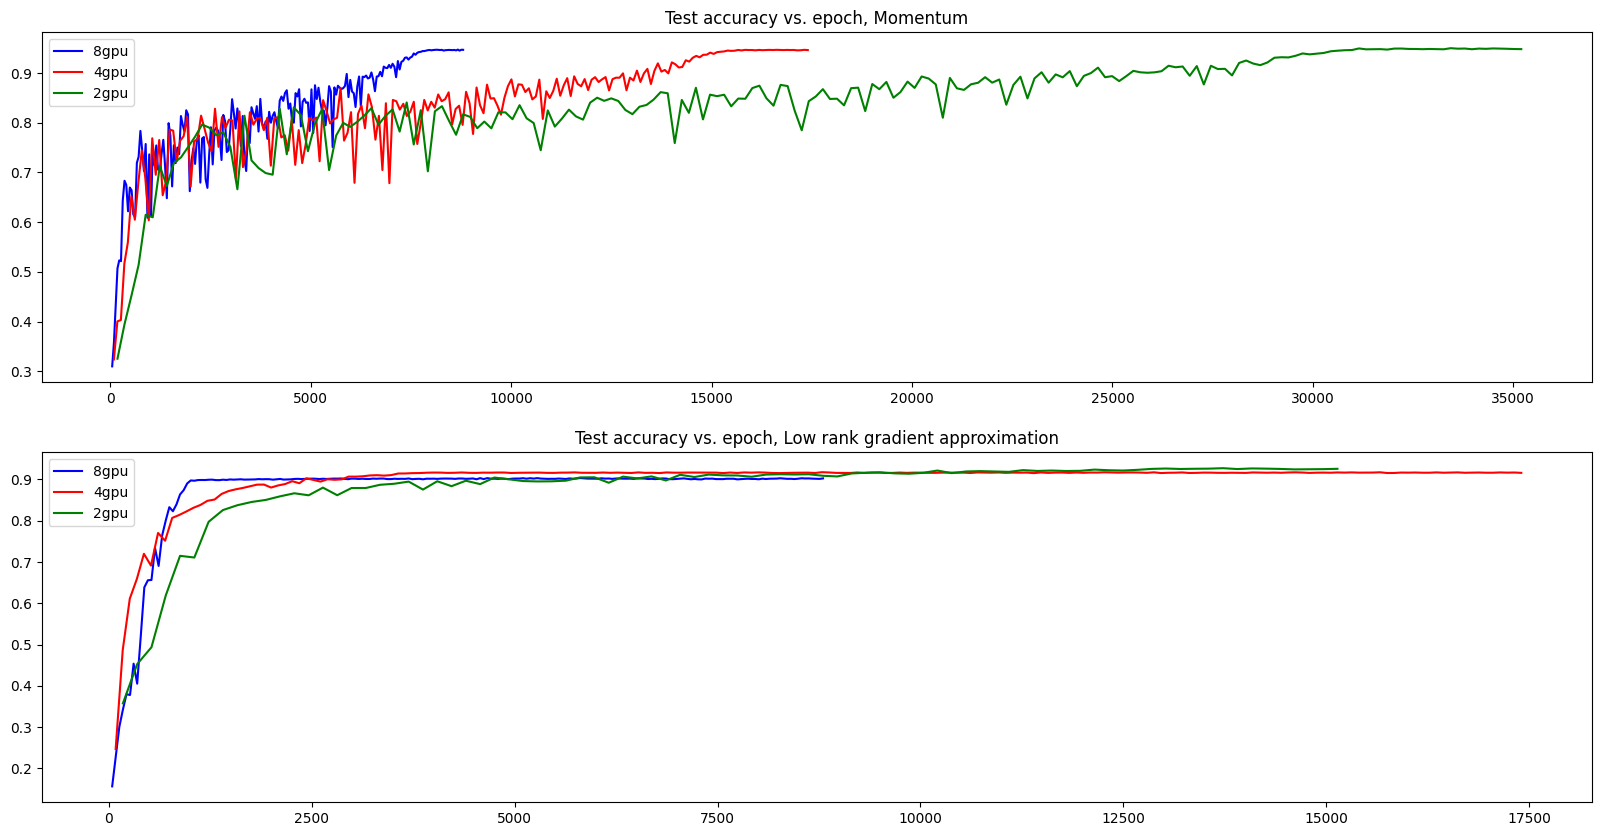

In [5]:
## First observe performance as gpu's increase
## by epoch
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
# performance by epoch is unchanged
ax1.set_title("Test accuracy vs. epoch, Momentum")
ax1.plot(momentum_8gpu['global_step'], momentum_8gpu['test/accuracy'],'b-', label='8gpu')
ax1.plot(momentum_4gpu['global_step'], momentum_4gpu['test/accuracy'], 'r-', label='4gpu')
ax1.plot(momentum_2gpu['global_step'], momentum_2gpu['test/accuracy'], 'g-', label='2gpu')
ax1.legend()
# performance by epoch is unchanged
ax2.set_title("Test accuracy vs. epoch, Low rank gradient approximation")
ax2.plot(baseline_8gpu['global_step'], baseline_8gpu['test/accuracy'], 'b-', label='8gpu')
ax2.plot(baseline_4gpu['global_step'], baseline_4gpu['test/accuracy'], 'r-', label='4gpu')
ax2.plot(baseline_2gpu['global_step'], baseline_2gpu['test/accuracy'], 'g-', label='2gpu')
ax2.legend()
## Note that the low rank approximation on 2 gpu's was only run for 15000 steps instead of the full 37400 steps.

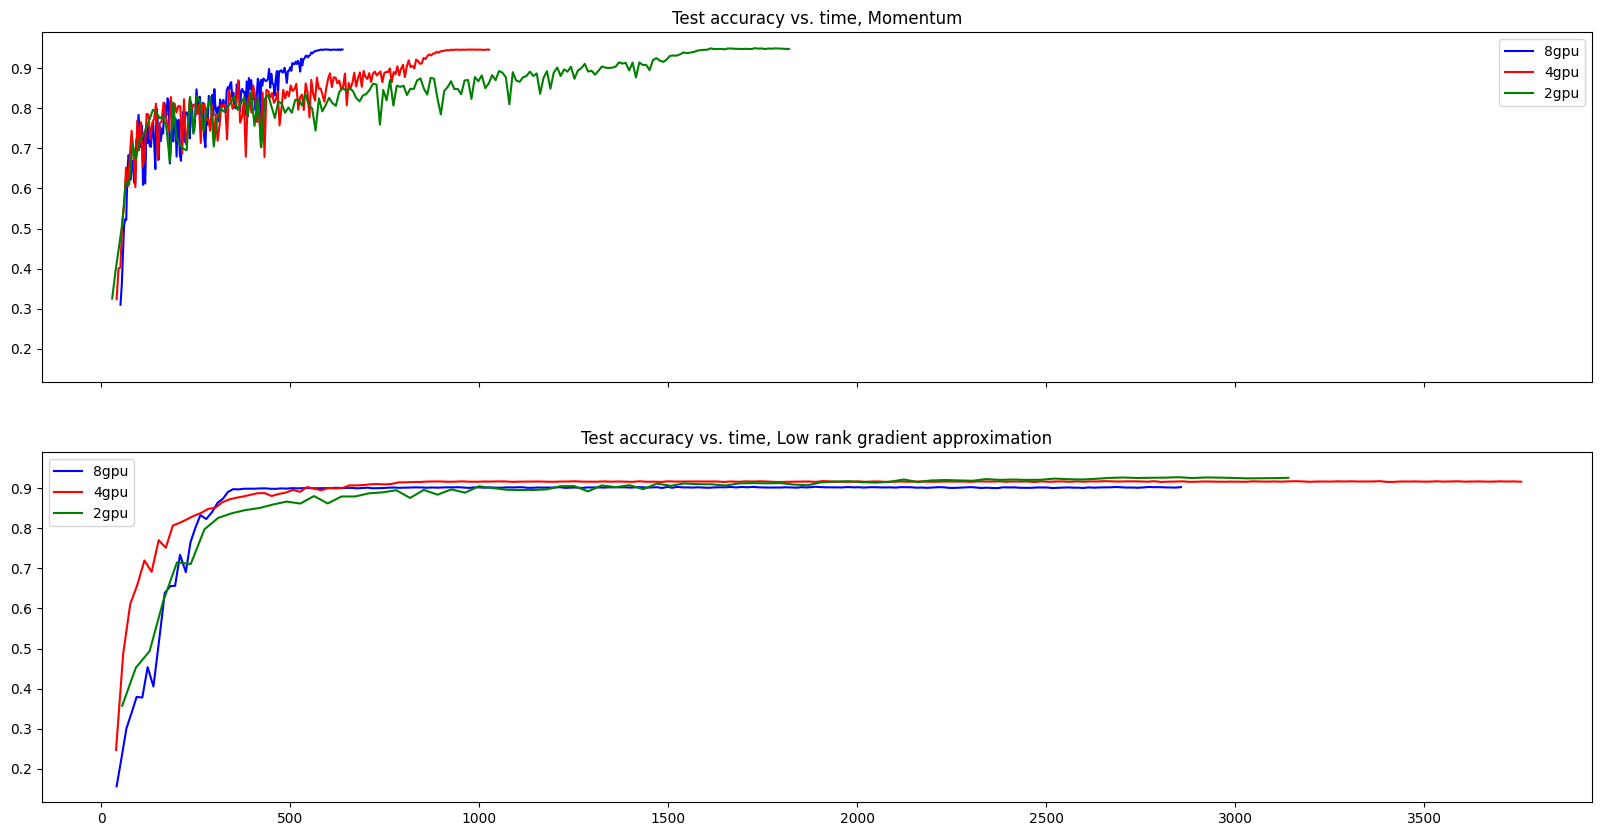

In [6]:
## observe performance by time
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
# performance by epoch is unchanged
ax1.set_title("Test accuracy vs. time, Momentum")
ax1.plot(momentum_8gpu['accumulated_submission_time'], momentum_8gpu['test/accuracy'],'b-', label='8gpu')
ax1.plot(momentum_4gpu['accumulated_submission_time'], momentum_4gpu['test/accuracy'], 'r-', label='4gpu')
ax1.plot(momentum_2gpu['accumulated_submission_time'], momentum_2gpu['test/accuracy'], 'g-', label='2gpu')
ax1.legend()
# performance by epoch is unchanged
ax2.set_title("Test accuracy vs. time, Low rank gradient approximation")
ax2.plot(baseline_8gpu['accumulated_submission_time'], baseline_8gpu['test/accuracy'], 'b-', label='8gpu')
ax2.plot(baseline_4gpu['accumulated_submission_time'], baseline_4gpu['test/accuracy'], 'r-', label='4gpu')
ax2.plot(baseline_2gpu['accumulated_submission_time'], baseline_2gpu['test/accuracy'], 'g-', label='2gpu')
ax2.legend()

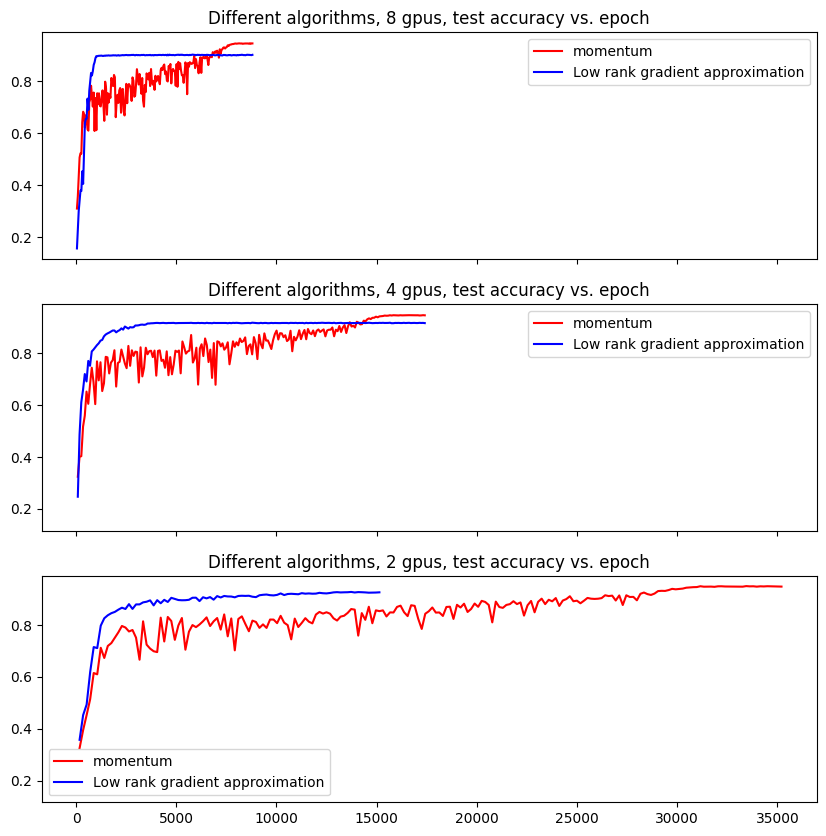

In [7]:
## compare 4 algorithms by fixing N_GPUS
## compare by epoch
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, sharey=True)
ax1.set_title("Different algorithms, 8 gpus, test accuracy vs. epoch")
ax1.plot(momentum_8gpu['global_step'], momentum_8gpu['test/accuracy'], 'r-', label='momentum')
ax1.plot(baseline_8gpu['global_step'], baseline_8gpu['test/accuracy'], 'b-',label='Low rank gradient approximation')
ax1.legend()
ax2.set_title("Different algorithms, 4 gpus, test accuracy vs. epoch")
ax2.plot(momentum_4gpu['global_step'], momentum_4gpu['test/accuracy'], 'r-', label='momentum')
ax2.plot(baseline_4gpu['global_step'], baseline_4gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax2.legend()
ax3.set_title("Different algorithms, 2 gpus, test accuracy vs. epoch")
ax3.plot(momentum_2gpu['global_step'], momentum_2gpu['test/accuracy'], 'r-', label='momentum')
ax3.plot(baseline_2gpu['global_step'], baseline_2gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax3.legend()

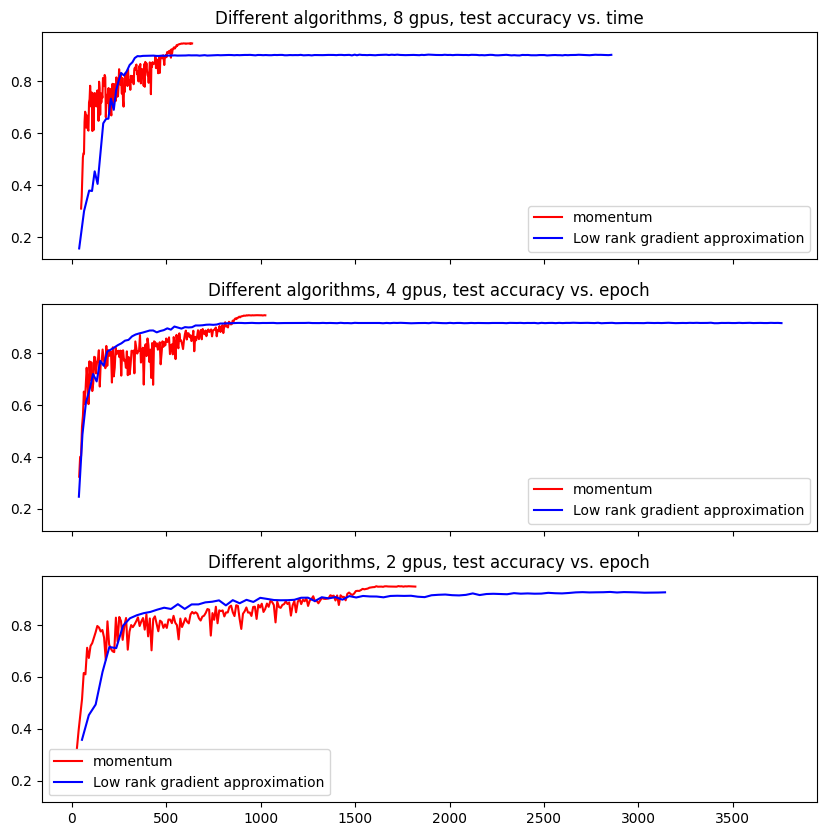

In [8]:
## compare by time
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=True, sharey=True)
ax1.set_title("Different algorithms, 8 gpus, test accuracy vs. time")
ax1.plot(momentum_8gpu['accumulated_submission_time'], momentum_8gpu['test/accuracy'], 'r-', label='momentum')
ax1.plot(baseline_8gpu['accumulated_submission_time'], baseline_8gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax1.legend()
ax2.set_title("Different algorithms, 4 gpus, test accuracy vs. epoch")
ax2.plot(momentum_4gpu['accumulated_submission_time'], momentum_4gpu['test/accuracy'], 'r-', label='momentum')
ax2.plot(baseline_4gpu['accumulated_submission_time'], baseline_4gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax2.legend()
ax3.set_title("Different algorithms, 2 gpus, test accuracy vs. epoch")
ax3.plot(momentum_2gpu['accumulated_submission_time'], momentum_2gpu['test/accuracy'], 'r-', label='momentum')
ax3.plot(baseline_2gpu['accumulated_submission_time'], baseline_2gpu['test/accuracy'], 'b-', label='Low rank gradient approximation')
ax3.legend()

### About the algorithms
  - baseline - Same as momentum, but before all reducing the gradient, simply replace the gradient with a low rank approximation. We use the 'randomized_svd' algorithm from the tensorly package. This is straight from the paper Algorithm 5.1 in ['Finding structure with randomness: Probabilistic algorithms for constructing matrix decompositions](https://arxiv.org/abs/0909.4061)
  - nadamw - nadamw algorithm taken from the [AlgoPerf benchmark](https://github.com/mlcommons/algorithmic-efficiency)
  - momentum - momentum algorithm taken from the [AlgoPerf benchmark](https://github.com/mlcommons/algorithmic-efficiency)

### Preliminary results on large batch sizes
From the below plots, we see that the previously good performance of our SVD approximation adjustments are outperformed by momentum.
Note that this is on a batch size of 8192.
But notice that our method takes a lot longer to warmup than momentum.
So it may be that more careful control of the learning rate is required here.
We hope that with more investigation and experimentation, we are able to push the limits of our algorithm and develop some rules of thumb for the hyperparameters and learning rates.

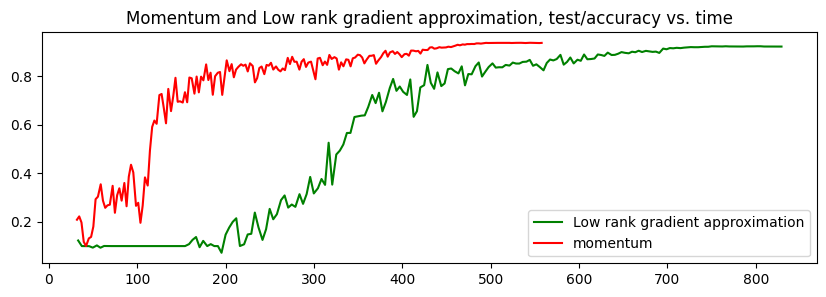

In [9]:
fig, ax = plt.subplots(figsize=(10,3))
ax.set_title("Momentum and Low rank gradient approximation, test/accuracy vs. time")
ax.plot(baseline_8gpu_8x_batch_lr2_again['accumulated_submission_time'],baseline_8gpu_8x_batch_lr2_again['test/accuracy'],'g-', label='Low rank gradient approximation')
ax.plot(momentum_8gpu_8x['accumulated_submission_time'],momentum_8gpu_8x['test/accuracy'],'r-', label='momentum')
ax.legend()

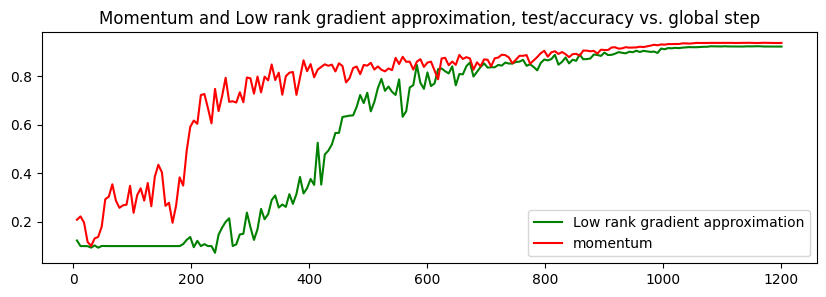

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
ax.set_title("Momentum and Low rank gradient approximation, test/accuracy vs. global step")
ax.plot(baseline_8gpu_8x_batch_lr2_again['global_step'],baseline_8gpu_8x_batch_lr2_again['test/accuracy'],'g-', label='Low rank gradient approximation')
ax.plot(momentum_8gpu_8x['global_step'],momentum_8gpu_8x['test/accuracy'],'r-', label='momentum')
ax.legend()

### Further investigations
- Perform the same experiment on different data sets, we hope to try tiny-imagenet next.
- We need to carefully choose a learning rate scheduler which is complementary to our algorithm
- We need to carefully study the interactions of the different hyperparameters: learning rate (and schedulers), batch size, number of GPUs, approximation rank, and more. A more complete study is needed.